GPT 모델 만들기
[ 평가 기준 ] 1. 트랜스포머와 비교해 변경한 부분 적기(블럭 단위) -> 코드블럭에 변경 사항을 주석으로 표시

기존 transformer에서 변경된 부분

1. 입력값이 변경됨

2. Positional Encoding -> embedding 으로 변경됨

3. 인코더 삭제됨

4. 디코더에서 인코더-디코더 멀티헤드 어텐션 삭제됨

5. 인코더, 디코더의 Nx 값 = 12

# 0. 버전확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기
### 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

Cloud shell에서 아래 명령어를 입력해 주세요.

$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

# Step 2. 데이터 전처리하기
### 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [3]:
data = pd.read_csv(os.path.expanduser("~/aiffel/transformer_chatbot/data/ChatbotData .csv"))

In [4]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 11823


In [5]:
data.head()
# A열의 2, 3행이 "여행은 언제나 좋죠." 로 중복값인 것을 확인함. 각 열의 중복값과 누락값을 확인하고자함.

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
# Q열과 A열 각각의 누락값 개수 확인
q_missing = data['Q'].isnull().sum()
a_missing = data['A'].isnull().sum()

print("Q 열의 누락값 개수:", q_missing)
print("A 열의 누락값 개수:", a_missing)

Q 열의 누락값 개수: 0
A 열의 누락값 개수: 0


In [7]:
# Q열과 A열 각각의 중복값 개수 확인
q_duplicates = data['Q'].duplicated().sum()
a_duplicates = data['A'].duplicated().sum()

print("Q 열의 중복값 개수:", q_duplicates)
print("A 열의 중복값 개수:", a_duplicates)

Q 열의 중복값 개수: 161
A 열의 중복값 개수: 4044


In [8]:
# 중복값을 갖는 Q열 데이터 확인
duplicate_q_data = data[data['Q'].duplicated(keep=False)]

print("중복값을 갖는 Q 열 데이터:")
print(duplicate_q_data)


중복값을 갖는 Q 열 데이터:
                             Q                        A  label
152    결혼이나 하지 왜 자꾸 나한테 화 내냐구!                   힘들겠네요.      0
189             고백하고 후회하면 어떡하지  후회는 후회를 낳을뿐이에요. 용기 내세요.      0
195                 고양이 키우고 싶어             자신을 먼저 키우세요.      0
196                 고양이 키우고 싶어             가족들과 상의해보세요.      0
226          공부는 내 체질이 아닌 것 같아                확신이 없나봐요.      0
...                        ...                      ...    ...
11658                  첫사랑 생각나           지금의 사랑에 충실하세요.      2
11731    커플여행이 나을까 그냥 우리끼리 갈까?         저는 둘이 가는 걸 좋아해요.      2
11732    커플여행이 나을까 그냥 우리끼리 갈까?          저는 둘이 가는 게 좋아요.      2
11818           훔쳐보는 것도 눈치 보임.       티가 나니까 눈치가 보이는 거죠!      2
11819           훔쳐보는 것도 눈치 보임.            훔쳐보는 거 티나나봐요.      2

[317 rows x 3 columns]


In [9]:
# Q열과 A열이 동시에 중복값을 갖는 데이터 확인
duplicate_qa_data = data[data.duplicated(subset=['Q', 'A'], keep=False)]

# 중복값의 개수 확인
num_duplicates = duplicate_qa_data.shape[0]

print("Q 열과 A 열이 동시에 중복값을 갖는 데이터 개수:", num_duplicates)
print("중복된 Q와 A 열 데이터:")
print(duplicate_qa_data)


Q 열과 A 열이 동시에 중복값을 갖는 데이터 개수: 146
중복된 Q와 A 열 데이터:
                            Q                        A  label
152   결혼이나 하지 왜 자꾸 나한테 화 내냐구!                   힘들겠네요.      0
189            고백하고 후회하면 어떡하지  후회는 후회를 낳을뿐이에요. 용기 내세요.      0
226         공부는 내 체질이 아닌 것 같아                확신이 없나봐요.      0
377                  기숙사 괜찮을까         혼자 사는 것보다 불편하겠죠.      0
592                 나는 좋은데 ….           현실의 벽에 부딪혔나봐요.      0
...                       ...                      ...    ...
8764                   환승 가능?               환승은 30분 안에      1
8780          회사 사람들이 아직도 불편해        회사에는 동료가 있을 뿐이에요.      1
8782     회사에는 왜 친구 같은 사람이 없을까      회사는 친구 사귀는 곳이 아니에요.      1
8789                    후련하달까              후련하니 다행이에요.      1
9541             내일 만나자고 해볼까?         멋지게 데이트 신청 해보세요.      2

[146 rows x 3 columns]


In [10]:
# 152번째 데이터의 Q와 A 값
target_q = data.loc[152, 'Q']
target_a = data.loc[152, 'A']

# 152번째 데이터와 같은 Q와 A 값을 갖는 데이터의 인덱스 찾기
duplicate_indices = data[(data['Q'] == target_q) & (data['A'] == target_a)].index.tolist()

print("152번째 데이터와 중복값을 갖는 데이터의 인덱스:", duplicate_indices)


152번째 데이터와 중복값을 갖는 데이터의 인덱스: [152, 5527]


In [11]:
# 5527번 데이터 출력
print(data.loc[5527])

Q        결혼이나 하지 왜 자꾸 나한테 화 내냐구!
A                         힘들겠네요.
label                          1
Name: 5527, dtype: object


In [12]:
# Q와 A 열이 동시에 같은 데이터를 하나만 남기고 삭제
data = data.drop_duplicates(subset=['Q', 'A'], keep='first').reset_index(drop=True)

# 결과 확인
print(data.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [13]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 11750


In [14]:
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []
    
    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        
        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # 양쪽 공백 제거
        sentence = sentence.strip()
        
        processed_texts.append(sentence)
    
    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []
    
    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()
        
        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]
        
        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))
    
    return filtered_texts


# Q열과 A열에 각각 전처리 및 불용어 제거 적용
data['Q_processed'] = preprocess_korean_text(data['Q'])
data['A_processed'] = preprocess_korean_text(data['A'])

data['Q_filtered'] = remove_stopwords(data['Q_processed'], stopwords)
data['A_filtered'] = remove_stopwords(data['A_processed'], stopwords)

# 결과 확인
print(data[['Q', 'Q_filtered', 'A', 'A_filtered']].head())


                 Q       Q_filtered            A    A_filtered
0           12시 땡!          12시 땡 !   하루가 또 가네요.   하루가 또 가네요 .
1      1지망 학교 떨어졌어      1지망 학교 떨어졌어    위로해 드립니다.    위로해 드립니다 .
2     3박4일 놀러가고 싶다     3박4일 놀러가고 싶다  여행은 언제나 좋죠.  여행은 언제나 좋죠 .
3  3박4일 정도 놀러가고 싶다  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.  여행은 언제나 좋죠 .
4          PPL 심하네          PPL 심하네   눈살이 찌푸려지죠.   눈살이 찌푸려지죠 .


In [15]:
# Q_filtered와 A_filtered 열의 개수 확인
q_filtered_count = data['Q_filtered'].count()
a_filtered_count = data['A_filtered'].count()

print("Q_filtered 열의 개수:", q_filtered_count)
print("A_filtered 열의 개수:", a_filtered_count)


Q_filtered 열의 개수: 11750
A_filtered 열의 개수: 11750


In [16]:
# Q열과 A열 삭제
data = data.drop(columns=['Q', 'A', 'Q_processed', 'A_processed'])
print(data.head())

   label       Q_filtered    A_filtered
0      0          12시 땡 !   하루가 또 가네요 .
1      0      1지망 학교 떨어졌어    위로해 드립니다 .
2      0     3박4일 놀러가고 싶다  여행은 언제나 좋죠 .
3      0  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠 .
4      0          PPL 심하네   눈살이 찌푸려지죠 .


In [17]:
# 열 이름 변경
data = data.rename(columns={'Q_filtered': 'questions', 'A_filtered': 'answers'})

# 결과 확인
print(data.head())

   label        questions       answers
0      0          12시 땡 !   하루가 또 가네요 .
1      0      1지망 학교 떨어졌어    위로해 드립니다 .
2      0     3박4일 놀러가고 싶다  여행은 언제나 좋죠 .
3      0  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠 .
4      0          PPL 심하네   눈살이 찌푸려지죠 .


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Q와 A 결합 (열 이름 변경 반영)
combined_data = [f"{q} <SEP> {a}" for q, a in zip(data['questions'], data['answers'])]

In [19]:
import pandas as pd

# 리스트를 DataFrame으로 변환
df = pd.DataFrame(combined_data, columns=['combined'])

# DataFrame 확인
print(df)


                                                combined
0                              12시 땡 ! <SEP> 하루가 또 가네요 .
1                           1지망 학교 떨어졌어 <SEP> 위로해 드립니다 .
2                        3박4일 놀러가고 싶다 <SEP> 여행은 언제나 좋죠 .
3                     3박4일 정도 놀러가고 싶다 <SEP> 여행은 언제나 좋죠 .
4                              PPL 심하네 <SEP> 눈살이 찌푸려지죠 .
...                                                  ...
11745          훔쳐보는 것도 눈치 보임 . <SEP> 티가 나니까 눈치가 보이는 거죠 !
11746               훔쳐보는 것도 눈치 보임 . <SEP> 훔쳐보는 거 티나나봐요 .
11747                         흑기사 해주는 짝남 . <SEP> 설렜겠어요 .
11748  힘든 연애 좋은 연애라는게 무슨 차이일까 ? <SEP> 잘 헤어질 수 있는 사이 여...
11749               힘들어서 결혼할까봐 <SEP> 도피성 결혼은 하지 않길 바라요 .

[11750 rows x 1 columns]


In [20]:
# 토크나이저 설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_data)
tokenized_data = tokenizer.texts_to_sequences(combined_data)

# 패딩 처리 (최대 길이에 맞춰 0으로 채움)
padded_data = pad_sequences(tokenized_data, padding='post')

# 포지셔널 임베딩 레이어 수정 (배치 차원을 고려하여 브로드캐스트)
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super(PositionalEmbedding, self).__init__()
        self.token_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]  # 시퀀스 길이
        positions = tf.range(start=0, limit=seq_len, delta=1)  # 위치 인덱스 생성
        positions = self.position_embedding(positions)  # 위치 임베딩 생성
        positions = tf.expand_dims(positions, axis=0)  # 배치 차원 추가
        positions = tf.tile(positions, [tf.shape(x)[0], 1, 1])  # 배치 크기에 맞게 타일링

        embedded_tokens = self.token_embedding(x)  # 토큰 임베딩 생성
        
        return embedded_tokens + positions  # 두 임베딩을 더함

# GPT 모델을 호출할 때, 디코더가 적절한 3차원 모양으로 입력을 받을 수 있도록 조정합니다.


# 임베딩 파라미터 설정
embedding_dim = 768  # GPT의 기본 임베딩 차원
max_seq_len = len(padded_data[0])  # max_seq_len 설정
vocab_size = len(tokenizer.word_index) + 1

# 포지셔널 임베딩 레이어 생성 및 적용
pos_embedding_layer = PositionalEmbedding(vocab_size=vocab_size, embed_dim=embedding_dim, max_len=max_seq_len)
inputs = tf.keras.Input(shape=(max_seq_len,))
encoded_inputs = pos_embedding_layer(inputs)

# 모델 구성
model = tf.keras.Model(inputs=inputs, outputs=encoded_inputs)

# 모델 구조 확인
model.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
positional_embedding (Positi (None, 28, 768)           15902208  
Total params: 15,902,208
Trainable params: 15,902,208
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


#### 9-7. 머리가 여러 개인 어텐션_멀티 헤드 어텐션 

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # Dense를 적용
    key = self.key_dense(key)        # Dense를 적용
    value = self.value_dense(value)  # Dense를 적용
    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # 머리 분리
    key = self.split_heads(key, batch_size)        # 머리 분리
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


#### 9-8. 마스킹

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [24]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#### 9-10. 디코더

In [25]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout, name="attention")(inputs, inputs, attention_mask=look_ahead_mask)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)
print("슝=3")


슝=3


In [26]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, max_len, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    embeddings = PositionalEmbedding(vocab_size, d_model, max_len)(inputs)

    outputs = embeddings
    for i in range(num_layers):
        outputs = decoder_layer(units, d_model, num_heads, dropout, name=f"decoder_layer_{i}")(
            inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 1. 단어장(Vocabulary) 만들기

In [27]:
import tensorflow_datasets as tfds

# questions와 answers를 합친 데이터 생성
combined_data = data['questions'] + data['answers']

# 단어장(Vocabulary) 생성 (questions + answers 대신 combined_data 사용)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(combined_data, target_vocab_size=2**14)
print("Vocabulary 생성 완료")

# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장 크기 설정
VOCAB_SIZE = tokenizer.vocab_size + 2
print("Vocabulary 크기:", VOCAB_SIZE)

Vocabulary 생성 완료
START_TOKEN의 번호 : [10428]
END_TOKEN의 번호 : [10429]
Vocabulary 크기: 10430


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [28]:
# 각 질문과 답변을 고유한 정수로 인코딩
encoded_questions = [tokenizer.encode(sentence) for sentence in data['questions']]
encoded_answers = [tokenizer.encode(sentence) for sentence in data['answers']]

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(encoded_questions[21]))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(encoded_answers[21]))

정수 인코딩 후의 21번째 질문 샘플: [10101, 2182, 3600]
정수 인코딩 후의 21번째 답변 샘플: [2332, 6579, 7, 5474, 108, 1]


In [29]:
# 질문과 답변을 합친 데이터를 고유한 정수로 인코딩
encoded_combined = [tokenizer.encode(sentence) for sentence in combined_data]

print('정수 인코딩 후의 21번째 샘플: {}'.format(encoded_combined[21]))

정수 인코딩 후의 21번째 샘플: [10101, 2182, 3600, 2332, 6579, 7, 5474, 108, 1]


combined_data의 최소 길이 : 1
combined_data의 최대 길이 : 30
combined_data의 평균 길이 : 7.6284255319148935


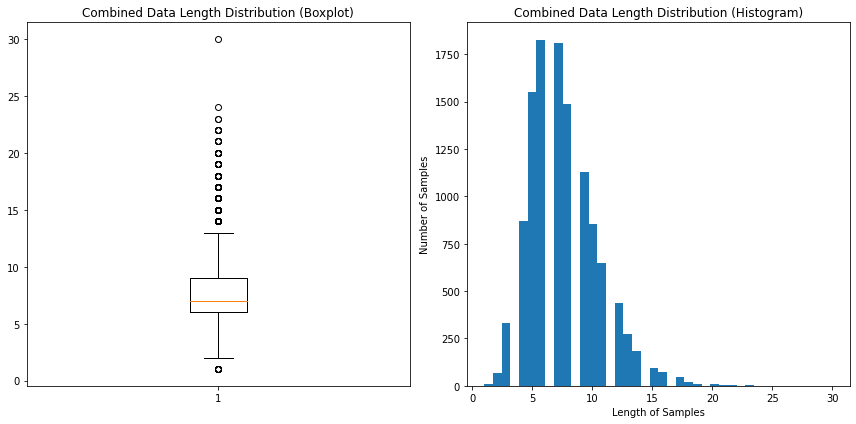

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# combined_data의 각 문장의 길이를 계산
combined_data_len = [len(s.split()) for s in combined_data]

# 길이 분포 출력
print('combined_data의 최소 길이 : {}'.format(np.min(combined_data_len)))
print('combined_data의 최대 길이 : {}'.format(np.max(combined_data_len)))
print('combined_data의 평균 길이 : {}'.format(np.mean(combined_data_len)))

# combined_data의 길이 분포 시각화
plt.figure(figsize=(12, 6))

# 박스 플롯(Boxplot)
plt.subplot(1, 2, 1)
plt.boxplot(combined_data_len)
plt.title('Combined Data Length Distribution (Boxplot)')

# 히스토그램(Histogram)
plt.subplot(1, 2, 2)
plt.hist(combined_data_len, bins=40)
plt.title('Combined Data Length Distribution (Histogram)')
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()



In [31]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [32]:
import tensorflow as tf

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter_combined(combined_data):
    tokenized_data = []
  
    for sentence in combined_data:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        tokenized_sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

        # 최대 길이 15 이하인 경우에만 데이터셋으로 허용
        if len(tokenized_sentence) <= MAX_LENGTH:
            tokenized_data.append(tokenized_sentence)
    
    # 최대 길이 15으로 모든 데이터셋을 패딩
    tokenized_data = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_data, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_data

# MAX_LENGTH 설정
MAX_LENGTH = 15

# combined_data를 사용하여 필터링 및 패딩 처리
padded_combined_data = tokenize_and_filter_combined(combined_data)

# 처리 결과 확인
print("패딩된 combined_data 샘플:", padded_combined_data[:3])  # 예시로 첫 3개 샘플 확인


패딩된 combined_data 샘플: [[10428  6949  1779  4777    34  4100    67  6931     1 10429     0     0
      0     0     0]
 [10428 10221    60   894 10204   867  1472  1562  4798     1 10429     0
      0     0     0]
 [10428 10223  1083  4032 10204  3156  8440  1049    36   660   116     1
  10429     0     0]]


In [33]:
# 결과 출력
print('단어장의 크기 :', VOCAB_SIZE)
print('필터링 후의 샘플 개수: {}'.format(len(padded_combined_data)))

단어장의 크기 : 10430
필터링 후의 샘플 개수: 9322


In [34]:
import tensorflow as tf
import numpy as np

# combined_data의 각 문장을 정수 인코딩
tokenized_combined_data = [START_TOKEN + tokenizer.encode(sentence) + END_TOKEN for sentence in combined_data]

# 리스트를 NumPy 배열로 변환
tokenized_combined_data = np.array(tokenized_combined_data, dtype=object)

# 정수 인코딩 과정을 수행하면서 샘플의 길이가 15를 넘는 경우 필터링
def tokenize_and_filter_combined(tokenized_combined_data):
    filtered_data = []
  
    for tokenized_sentence in tokenized_combined_data:
        if len(tokenized_sentence) <= MAX_LENGTH:
            filtered_data.append(tokenized_sentence)
    
    # 리스트를 NumPy 배열로 변환 (패딩 처리를 위해)
    filtered_data = np.array(filtered_data, dtype=object)

    # 최대 길이 15으로 모든 데이터셋을 패딩
    filtered_data = tf.keras.preprocessing.sequence.pad_sequences(
        filtered_data, maxlen=MAX_LENGTH, padding='post')
    
    return filtered_data

# 정수 인코딩 및 필터링 수행
padded_combined_data = tokenize_and_filter_combined(tokenized_combined_data)

# BATCH_SIZE와 BUFFER_SIZE 설정
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 데이터셋 구성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': padded_combined_data[:, :-1]  # 마지막 토큰을 제외한 시퀀스 (입력)
    },
    {
        'outputs': padded_combined_data[:, 1:]  # 첫 번째 토큰을 제외한 시퀀스 (정답, 예측할 대상)
    },
))

# 데이터셋 준비
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("슝=3")


슝=3


In [35]:
def gpt_model(vocab_size,
              num_layers,
              units,
              d_model,
              num_heads,
              dropout,
              max_len,
              name="gpt"):
    # 디코더 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # GPT에서는 look_ahead_mask를 사용하여 미래의 단어를 마스킹
    look_ahead_mask = tf.keras.layers.Lambda(
        lambda x: tf.linalg.band_part(tf.ones((tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[1])), -1, 0),
        name='look_ahead_mask')(inputs)
    
    # 포지셔널 임베딩 적용
    embeddings = PositionalEmbedding(vocab_size, d_model, max_len)(inputs)  # 차원이 맞는 임베딩 적용

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        max_len=max_len
    )(inputs=[embeddings, look_ahead_mask])

    # 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    # GPT 모델은 단일 입력만 사용
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# 하이퍼파라미터 설정
NUM_LAYERS = 12
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
MAX_LEN = 15

# GPT 모델 생성
model = gpt_model(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len=MAX_LEN,
    name="gpt"
)

# 모델 구조 출력
model.summary()


ValueError: Shape must be rank 3 but is rank 4
	 for 0th input and equation: abc,cde->abde for '{{node decoder/decoder_layer_0/attention/query/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="abc,cde->abde"](decoder/positional_embedding_2/add, decoder/decoder_layer_0/attention/query/einsum/Einsum/ReadVariableOp)' with input shapes: [?,?,256,256], [256,8,256].

In [ ]:
# 손실함수 정의

In [ ]:
def loss_function(y_true, y_pred):
    # y_true를 정리할 필요가 없을 수 있습니다. 필요시 리쉐이핑 가능
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    # SparseCategoricalCrossentropy 손실 함수 적용
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 마스크 생성 및 차원 맞추기 (마스크를 [batch_size, seq_len, 1]로 확장)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  # [batch_size, seq_len, 1]
    
    # 손실 텐서와 마스크를 곱함
    loss = tf.multiply(loss, mask)

    # 마스킹된 손실의 평균 계산
    return tf.reduce_mean(loss)


print("슝=3")


In [ ]:
# 커스텀 된 학습률

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

In [ ]:
# 모델 컴파일

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # y_pred에서 가장 높은 확률을 가진 단어를 예측 (argmax를 통해 예측 레이블 생성)
    y_pred = tf.argmax(y_pred, axis=-1)
    
    # y_true의 차원과 y_pred의 차원을 일치시키기 위해 y_true의 차원을 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))
    
    # sparse_categorical_accuracy 함수로 정확도 계산
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

In [ ]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

loss = history.history['loss']
accuracy = history.history['accuracy']

In [ ]:
print(loss)

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('배고파')

In [ ]:
output = predict('오늘 놀러갈거야')

In [ ]:
output = predict('힘들어')

회고

트랜스포머 모델의 인코더와 디코더 구조를 알고 모델을 만드니 과정이 조금은 더 잘 이해가 되었다.
이전에 자연어처리에서 배웠던 문장 평균 길이 구하기 위해 사분위로 나타내는 것과 데이터 표준화 등이 사용되어서 복습이 되었다.

첫번째로 변경한 파라미터는 max_length이다.
max_length를 설정할 때 길이를 길게 해서 모든 데이터를 살리는 대신 패딩이 많이 들어가는게 나을지, 길이를 짧게해서 일부 데이터는 제외시키되 패딩을
적게 넣는 것이 좋을지 고민이 되었는데 데이터의 토큰 길이가 짧다보니 이럴 경우에는 후자가 더 좋다고 했고, 실제로 결과도 accuracy를 봤을 때 더 높았다.

두번째로 변경한 파라미터는 dropout이다.
dropout값을 노드 설정값인 0.1에서 0.05로 낮추었는데 loss 값이 더 증가하였다.
추가적인 실험을 통해 최적화가 더 필요할 것 같다.

마지막으로 알게된 것은 챗봇 모델에서 accuracy보다는 loss 값을 확인하는 것이 더 의미있다고 하였는데 구체적인 설명은 이해를 못했다..

여유롭게 학습해서 좋았다.